# HOXA1 Knockdown: Differential Transcript Expression with edgePython

This notebook analyzes transcript-level RNA-seq data from a **HOXA1 knockdown** experiment using **edgePython**, a Python implementation of edgeR.

## Dataset

Transcript-level counts quantified with kallisto from 6 samples: 3 scrambled controls and 3 HOXA1 knockdown (HOXA1KD) replicates. The data are from [Trapnell et al. (2013)](https://doi.org/10.1038/nbt.2594).

In [1]:
import sys, subprocess

IN_COLAB = 'google.colab' in sys.modules

try:
    import edgepython as ep
except ImportError:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'edgepython'])
    import edgepython as ep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

BASE_URL = 'https://raw.githubusercontent.com/pachterlab/edgePython/main/examples/hoxa1/data'

counts_df = pd.read_csv(f'{BASE_URL}/counts.tsv', sep='\t', index_col=0)
sample_info = pd.read_csv(f'{BASE_URL}/sample_info.tsv', sep='\t')

print(f'Count matrix: {counts_df.shape[0]:,} transcripts x {counts_df.shape[1]} samples')
sample_info

Count matrix: 207,175 transcripts x 6 samples


,sample,group
0,SRR493366,scramble
1,SRR493367,scramble
2,SRR493368,scramble
3,SRR493369,HOXA1KD
4,SRR493370,HOXA1KD
5,SRR493371,HOXA1KD


In [2]:
plt.rcParams.update({
    'figure.dpi': 120, 'font.size': 11, 'axes.titlesize': 13,
    'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'legend.fontsize': 10, 'figure.figsize': (8, 5),
    'axes.spines.top': False, 'axes.spines.right': False,
})

group_colors = {'scramble': '#4DAF4A', 'HOXA1KD': '#E41A1C'}
sample_names = counts_df.columns.tolist()
group = sample_info.set_index('sample').loc[sample_names, 'group'].values

## 1. Create DGEList

In [3]:
transcript_ids = counts_df.index.values.astype(str)
genes_df = pd.DataFrame({'TranscriptID': transcript_ids})
d = ep.make_dgelist(counts_df.values.astype(float), group=group, genes=genes_df)
print(f'DGEList: {d["counts"].shape[0]:,} transcripts, {d["counts"].shape[1]} samples')
print(f'Library sizes: {d["samples"]["lib.size"].values.astype(int)}')

DGEList: 207,175 transcripts, 6 samples
Library sizes: [14147251 16174039 20376670 16671077 18672336 21608154]


## 2. Library Sizes

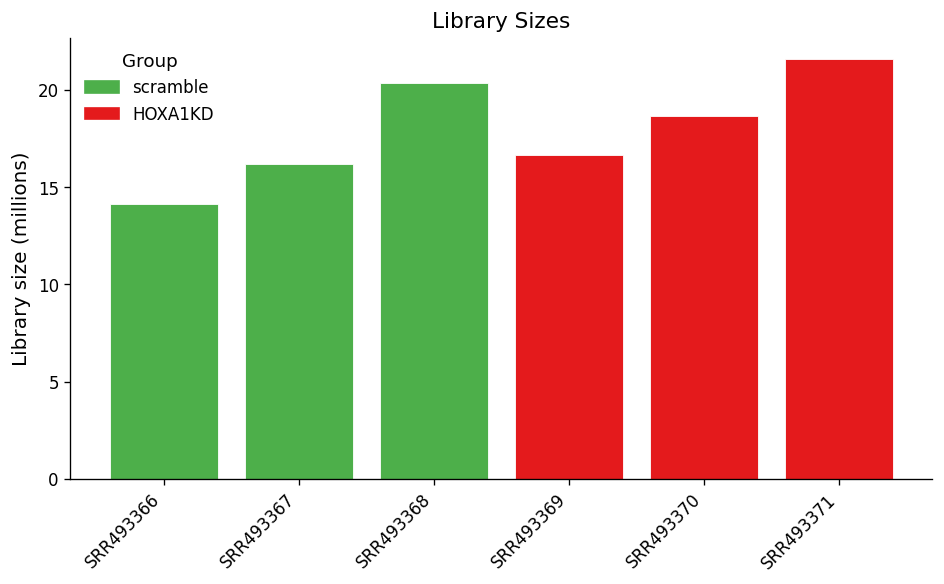

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
lib_sizes = d['samples']['lib.size'].values / 1e6
colors = [group_colors[g] for g in group]
ax.bar(range(len(lib_sizes)), lib_sizes, color=colors, edgecolor='white', linewidth=0.5)
ax.set_xticks(range(len(sample_names)))
ax.set_xticklabels(sample_names, rotation=45, ha='right')
ax.set_ylabel('Library size (millions)')
ax.set_title('Library Sizes')
handles = [mpatches.Patch(color=group_colors[g], label=g) for g in group_colors]
ax.legend(handles=handles, title='Group', frameon=False)
plt.tight_layout()
plt.show()

## 3. Filter Low-Expression Transcripts

We keep transcripts with CPM > 0.5 in at least 2 samples.

In [5]:
cpm_vals = ep.cpm(d)
keep = np.sum(cpm_vals > 0.5, axis=1) >= 2
print(f'Transcripts before filtering: {d["counts"].shape[0]:,}')
print(f'Transcripts after filtering:  {np.sum(keep):,}')
print(f'Transcripts removed:          {np.sum(~keep):,}')

d_filt = ep.make_dgelist(d['counts'][keep, :], group=group,
                         genes=pd.DataFrame({'TranscriptID': transcript_ids[keep]}))

Transcripts before filtering: 207,175
Transcripts after filtering:  54,588
Transcripts removed:          152,587


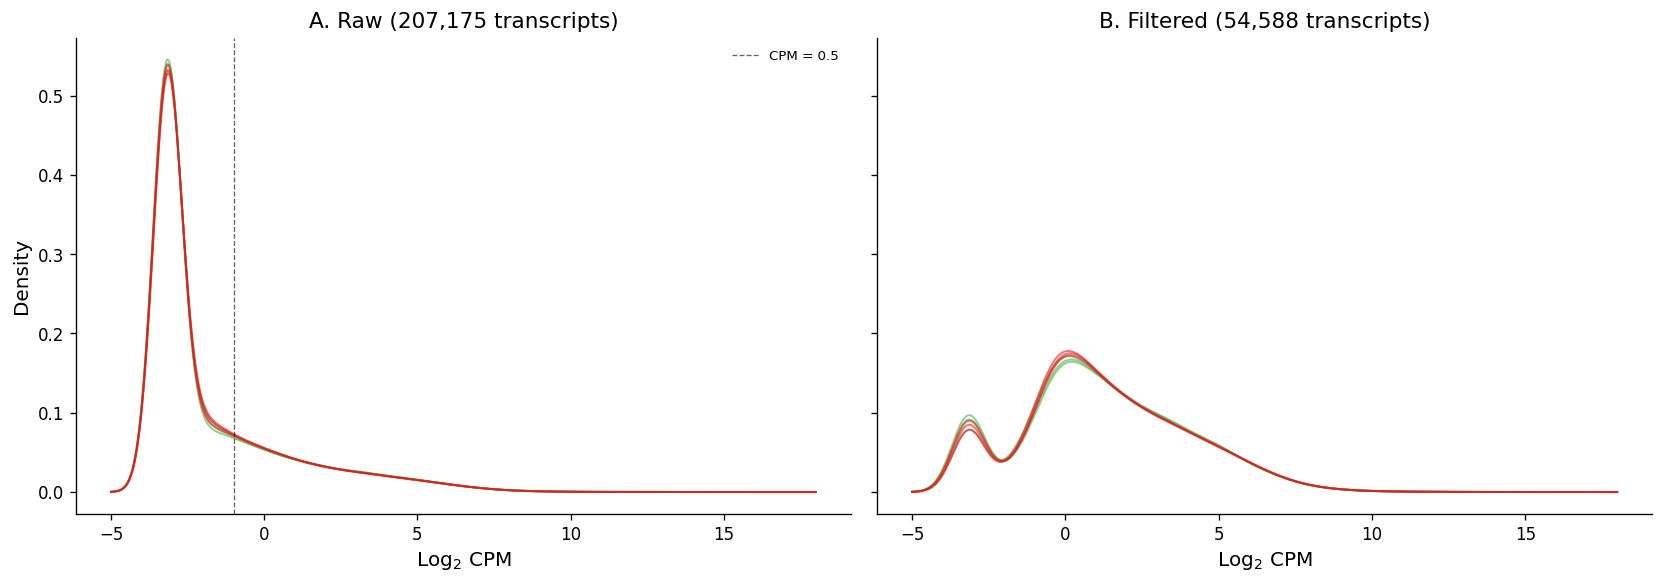

In [6]:
from scipy.stats import gaussian_kde

full_lib_size = d['samples']['lib.size'].values
logcpm_before = ep.cpm(d, log=True)
logcpm_after = ep.cpm(d['counts'][keep, :], lib_size=full_lib_size, log=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True, sharex=True)
x_grid = np.linspace(-5, 18, 500)

for i in range(len(sample_names)):
    c = group_colors[group[i]]
    kde_before = gaussian_kde(logcpm_before[:, i], bw_method=0.2)
    ax1.plot(x_grid, kde_before(x_grid), color=c, alpha=0.6, linewidth=1.2)
    kde_after = gaussian_kde(logcpm_after[:, i], bw_method=0.2)
    ax2.plot(x_grid, kde_after(x_grid), color=c, alpha=0.6, linewidth=1.2)

ax1.set_xlabel('Log$_2$ CPM'); ax1.set_ylabel('Density')
ax1.set_title(f'A. Raw ({logcpm_before.shape[0]:,} transcripts)')
ax1.axvline(x=np.log2(0.5), color='black', linestyle='--', linewidth=0.8,
            alpha=0.6, label='CPM = 0.5')
ax1.legend(frameon=False, fontsize=8)
ax2.set_xlabel('Log$_2$ CPM')
ax2.set_title(f'B. Filtered ({logcpm_after.shape[0]:,} transcripts)')
plt.tight_layout()
plt.show()

## 4. TMM Normalization

In [7]:
d_filt = ep.calc_norm_factors(d_filt)
print('Normalization factors:')
print(d_filt['samples'][['group', 'lib.size', 'norm.factors']])

Normalization factors:
            group    lib.size  norm.factors
Sample1  scramble  14038355.0      1.000634
Sample2  scramble  16049848.0      1.000864
Sample3  scramble  20221996.0      0.990410
Sample4   HOXA1KD  16543207.0      1.008990
Sample5   HOXA1KD  18525944.0      1.001107
Sample6   HOXA1KD  21443025.0      0.998086


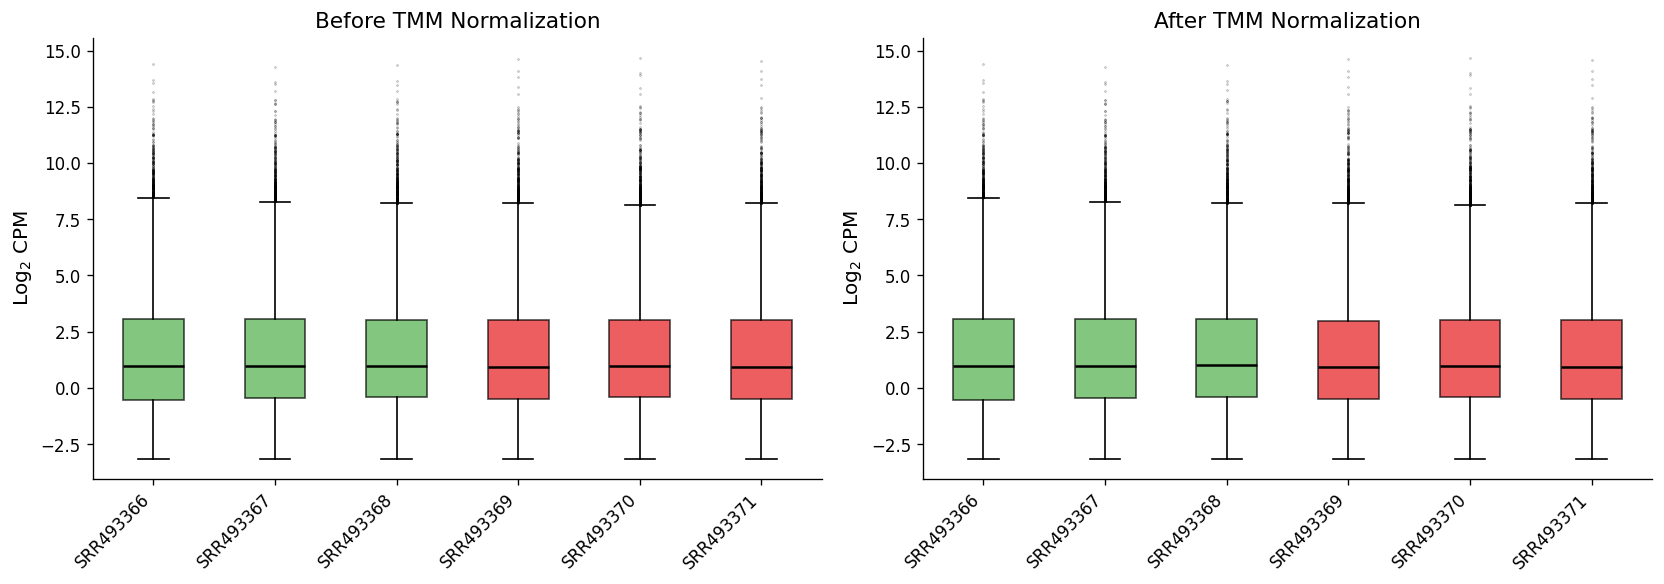

In [8]:
import copy
logcpm_norm = ep.cpm(d_filt, log=True)
d_unnorm = copy.deepcopy(d_filt)
d_unnorm['samples']['norm.factors'] = 1.0
logcpm_unnorm = ep.cpm(d_unnorm, log=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for ax, data, title in [(ax1, logcpm_unnorm, 'Before TMM Normalization'),
                         (ax2, logcpm_norm, 'After TMM Normalization')]:
    bp = ax.boxplot([data[:, i] for i in range(data.shape[1])],
                    patch_artist=True, medianprops=dict(color='black', linewidth=1.5),
                    flierprops=dict(marker='.', markersize=1, alpha=0.3))
    for patch, g in zip(bp['boxes'], group):
        patch.set_facecolor(group_colors[g]); patch.set_alpha(0.7)
    ax.set_xticklabels(sample_names, rotation=45, ha='right')
    ax.set_ylabel('Log$_2$ CPM'); ax.set_title(title)
plt.tight_layout()
plt.show()

## 5. MDS Plot

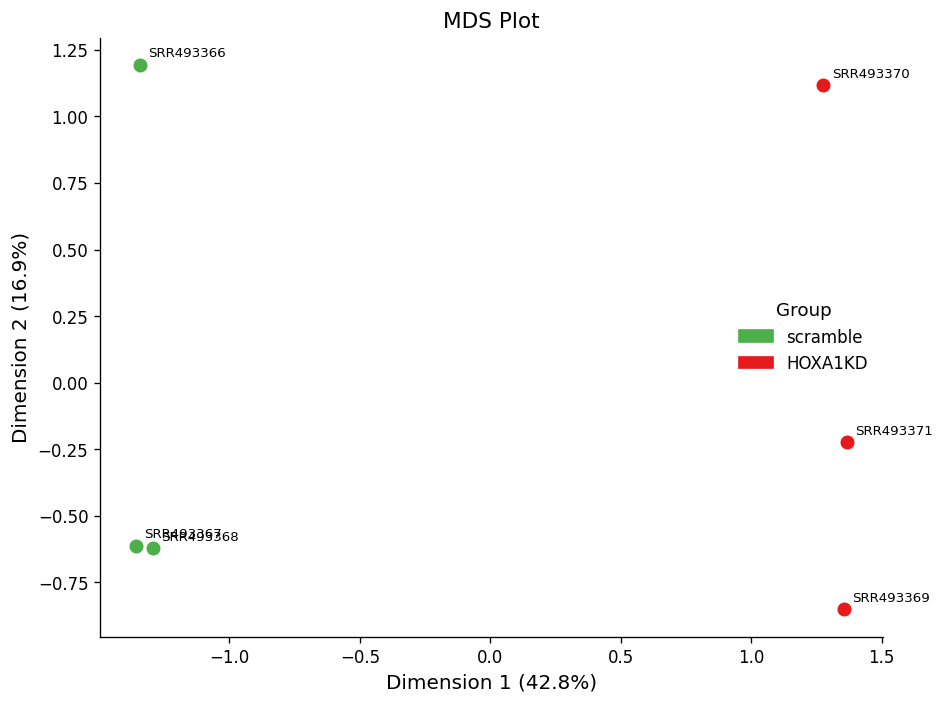

In [9]:
fig, ax = ep.plot_mds(d_filt)
collections = ax.collections
if len(collections) > 0:
    xy = collections[0].get_offsets()
    collections[0].remove()
    for txt in ax.texts[:]:
        txt.remove()
    for i in range(len(xy)):
        ax.scatter(xy[i, 0], xy[i, 1], c=group_colors[group[i]], s=80,
                   edgecolors='white', linewidth=0.5, zorder=5)
        ax.annotate(sample_names[i], (xy[i, 0], xy[i, 1]),
                    fontsize=8, ha='left', va='bottom',
                    xytext=(5, 3), textcoords='offset points')
    handles = [mpatches.Patch(color=group_colors[g], label=g) for g in group_colors]
    ax.legend(handles=handles, title='Group', frameon=False)
ax.set_title('MDS Plot')
plt.tight_layout()
plt.show()

## 6. Design Matrix and Dispersion Estimation

In [10]:
# Design: intercept + HOXA1KD effect
condition = (group == 'HOXA1KD').astype(float)
design = np.column_stack([np.ones(len(group)), condition])
print('Design matrix (intercept + HOXA1KD):')
print(pd.DataFrame(design, columns=['Intercept', 'HOXA1KD'], index=sample_names))

Design matrix (intercept + HOXA1KD):
           Intercept  HOXA1KD
SRR493366        1.0      0.0
SRR493367        1.0      0.0
SRR493368        1.0      0.0
SRR493369        1.0      1.0
SRR493370        1.0      1.0
SRR493371        1.0      1.0


In [11]:
d_filt = ep.estimate_disp(d_filt, design=design)
print(f'Common dispersion: {d_filt["common.dispersion"]:.6f}')
print(f'Common BCV:        {np.sqrt(d_filt["common.dispersion"]):.4f}')

Common dispersion: 0.528990
Common BCV:        0.7273


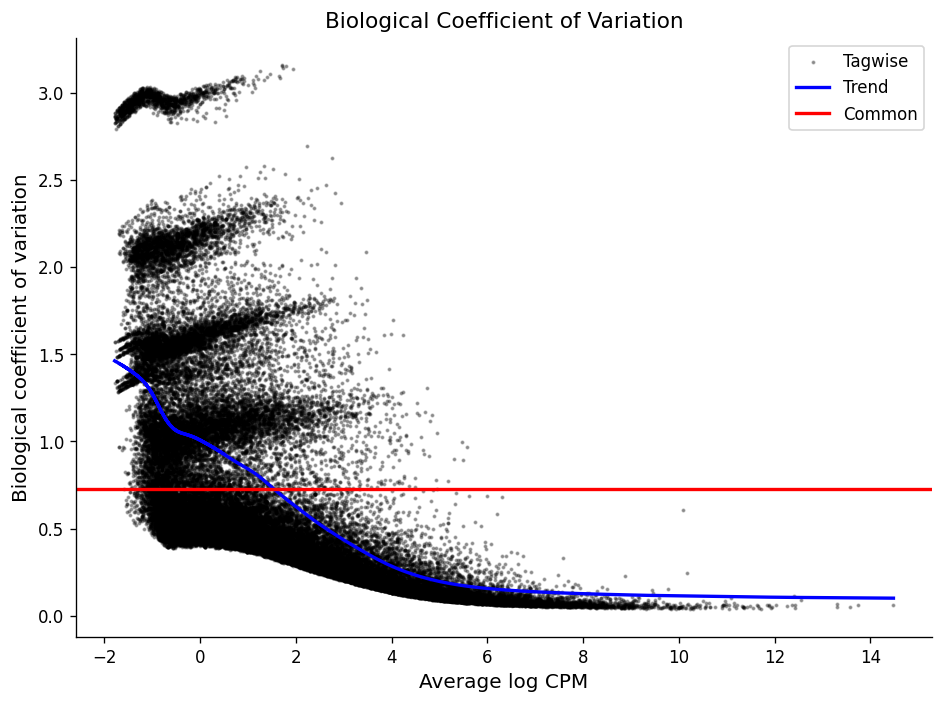

In [12]:
fig, ax = ep.plot_bcv(d_filt)
ax.set_title('Biological Coefficient of Variation')
plt.tight_layout()
plt.show()

## 7. Quasi-Likelihood GLM Fit

In [13]:
fit = ep.glm_ql_fit(d_filt, design=design)
print(f'Prior df: {fit["df.prior"]:.4f}')

Prior df: 2.4661


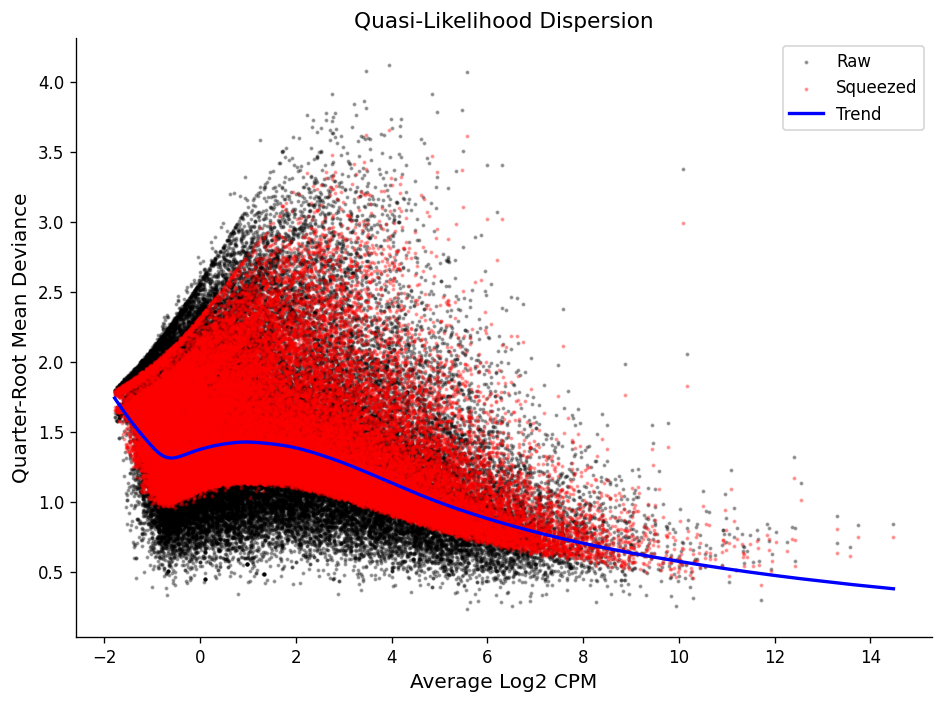

In [14]:
fig, ax = ep.plot_ql_disp(fit)
ax.set_title('Quasi-Likelihood Dispersion')
plt.tight_layout()
plt.show()

## 8. Differential Expression: HOXA1KD vs Scramble

In [15]:
# Test the HOXA1KD coefficient (column index 1)
result = ep.glm_ql_ftest(fit, coef=1)
tt = ep.top_tags(result, n=np.inf, sort_by='PValue')
table = tt['table']

dt = ep.decide_tests(result)
n_up = int(np.sum(dt > 0))
n_down = int(np.sum(dt < 0))
n_ns = int(np.sum(dt == 0))
print(f'DE summary (FDR < 0.05): Up={n_up:,}, Down={n_down:,}, NS={n_ns:,}')
print()
print('Top 20 differentially expressed transcripts:')
table.head(20)

DE summary (FDR < 0.05): Up=4,123, Down=4,511, NS=45,954

Top 20 differentially expressed transcripts:


,TranscriptID,logFC,logCPM,PValue,F,FDR
7677,ENST00000263734.5,-1.908303,8.004889,2.163375e-10,4350.439016,0.000006
47921,ENST00000244741.10,1.829438,10.647323,2.488522e-10,4165.786868,0.000006
14461,ENST00000421017.6,-1.404688,8.782866,4.351072e-10,3503.749113,0.000006
6775,ENST00000645237.2,1.998394,8.314256,4.696755e-10,3421.753205,0.000006
13460,ENST00000359092.7,-2.325107,7.107494,7.030615e-10,3019.995471,0.000006
27963,ENST00000249749.7,3.851646,6.248048,7.082017e-10,3017.071856,0.000006
36933,ENST00000341590.8,-2.445392,6.766277,7.952594e-10,2907.019433,0.000006
28826,ENST00000296677.5,3.350812,7.060789,8.945108e-10,2803.375725,0.000006
52243,ENST00000234590.10,-1.358642,10.031724,1.034361e-09,2679.145404,0.000006
14155,ENST00000257527.9,1.136470,9.598123,2.016571e-09,2178.243207,0.000010


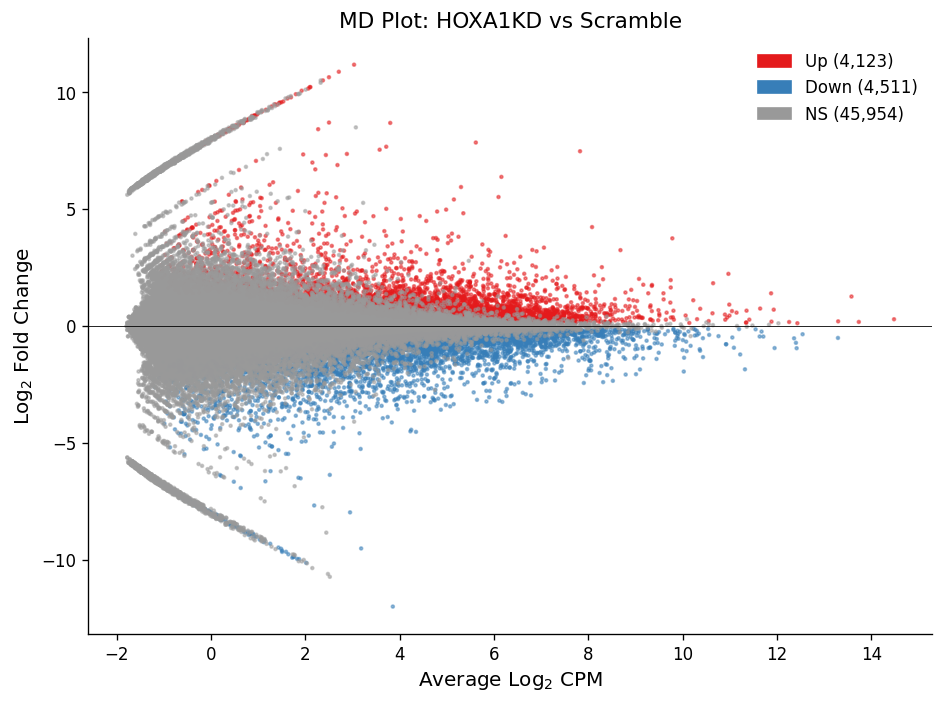

In [16]:
# MD plot
fig, ax = plt.subplots(figsize=(8, 6))
logfc = table['logFC'].values
logcpm_mean = table['logCPM'].values
fdr = table['FDR'].values
sig = fdr < 0.05
colors_md = np.where(sig & (logfc > 0), '#E41A1C',
             np.where(sig & (logfc < 0), '#377EB8', '#999999'))
ax.scatter(logcpm_mean, logfc, c=colors_md, s=3, alpha=0.5, rasterized=True)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Average Log$_2$ CPM'); ax.set_ylabel('Log$_2$ Fold Change')
ax.set_title('MD Plot: HOXA1KD vs Scramble')
handles_md = [mpatches.Patch(color='#E41A1C', label=f'Up ({n_up:,})'),
              mpatches.Patch(color='#377EB8', label=f'Down ({n_down:,})'),
              mpatches.Patch(color='#999999', label=f'NS ({n_ns:,})')]
ax.legend(handles=handles_md, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

## 9. Volcano Plot

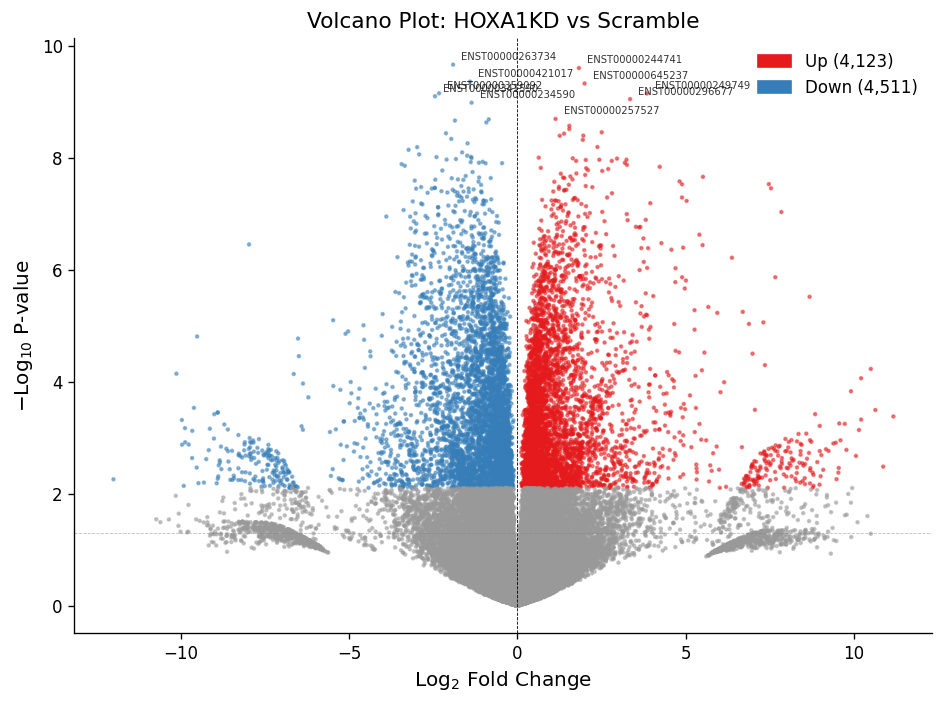

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
neglogp = -np.log10(np.maximum(table['PValue'].values, 1e-300))
colors_v = np.where(sig & (logfc > 0), '#E41A1C',
            np.where(sig & (logfc < 0), '#377EB8', '#999999'))
ax.scatter(logfc, neglogp, c=colors_v, s=3, alpha=0.5, rasterized=True)
ax.axvline(x=0, color='black', linewidth=0.5, linestyle='--')
ax.axhline(y=-np.log10(0.05), color='grey', linewidth=0.5, linestyle='--', alpha=0.5)
ax.set_xlabel('Log$_2$ Fold Change')
ax.set_ylabel('$-$Log$_{10}$ P-value')
ax.set_title('Volcano Plot: HOXA1KD vs Scramble')

# Label top 10 most significant transcripts
top10 = table.head(10)
for _, row in top10.iterrows():
    tid = row['TranscriptID']
    # Shorten long Ensembl IDs for display
    label = tid.split('.')[0] if '.' in str(tid) else str(tid)[:15]
    lfc_i = row['logFC']
    nlp_i = -np.log10(max(row['PValue'], 1e-300))
    ax.annotate(label, (lfc_i, nlp_i), fontsize=6, alpha=0.8,
                xytext=(5, 3), textcoords='offset points')

handles_v = [mpatches.Patch(color='#E41A1C', label=f'Up ({n_up:,})'),
             mpatches.Patch(color='#377EB8', label=f'Down ({n_down:,})')]
ax.legend(handles=handles_v, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

## 10. TREAT Analysis

TREAT tests whether transcripts are differentially expressed by more than a log-fold-change threshold of log2(1.5) = 0.58.

In [18]:
treat_result = ep.glm_treat(fit, coef=1, lfc=0.58)
dt_treat = ep.decide_tests(treat_result)
n_up_treat = int(np.sum(dt_treat > 0))
n_down_treat = int(np.sum(dt_treat < 0))
print(f'TREAT (|logFC| > 0.58, FDR < 0.05): Up={n_up_treat:,}, Down={n_down_treat:,}')

tt_treat = ep.top_tags(treat_result, n=20, sort_by='PValue')
print('\nTop 20 TREAT results:')
tt_treat['table']

TREAT (|logFC| > 0.58, FDR < 0.05): Up=1,311, Down=1,581

Top 20 TREAT results:


,TranscriptID,logFC,logCPM,PValue,FDR
7677,ENST00000263734.5,-1.908303,8.004889,5.336951e-10,0.000011
47921,ENST00000244741.10,1.829438,10.647323,6.620106e-10,0.000011
27963,ENST00000249749.7,3.851646,6.248048,8.890761e-10,0.000011
6775,ENST00000645237.2,1.998394,8.314256,1.065531e-09,0.000011
28826,ENST00000296677.5,3.350812,7.060789,1.188277e-09,0.000011
13460,ENST00000359092.7,-2.325107,7.107494,1.286816e-09,0.000011
36933,ENST00000341590.8,-2.445392,6.766277,1.376004e-09,0.000011
14461,ENST00000421017.6,-1.404688,8.782866,2.379476e-09,0.000016
6809,ENST00000223095.5,-1.853622,11.322405,5.576019e-09,0.000032
21397,ENST00000298198.5,2.507613,6.130378,5.951536e-09,0.000032


## 11. Heatmap of Top 50 DE Transcripts

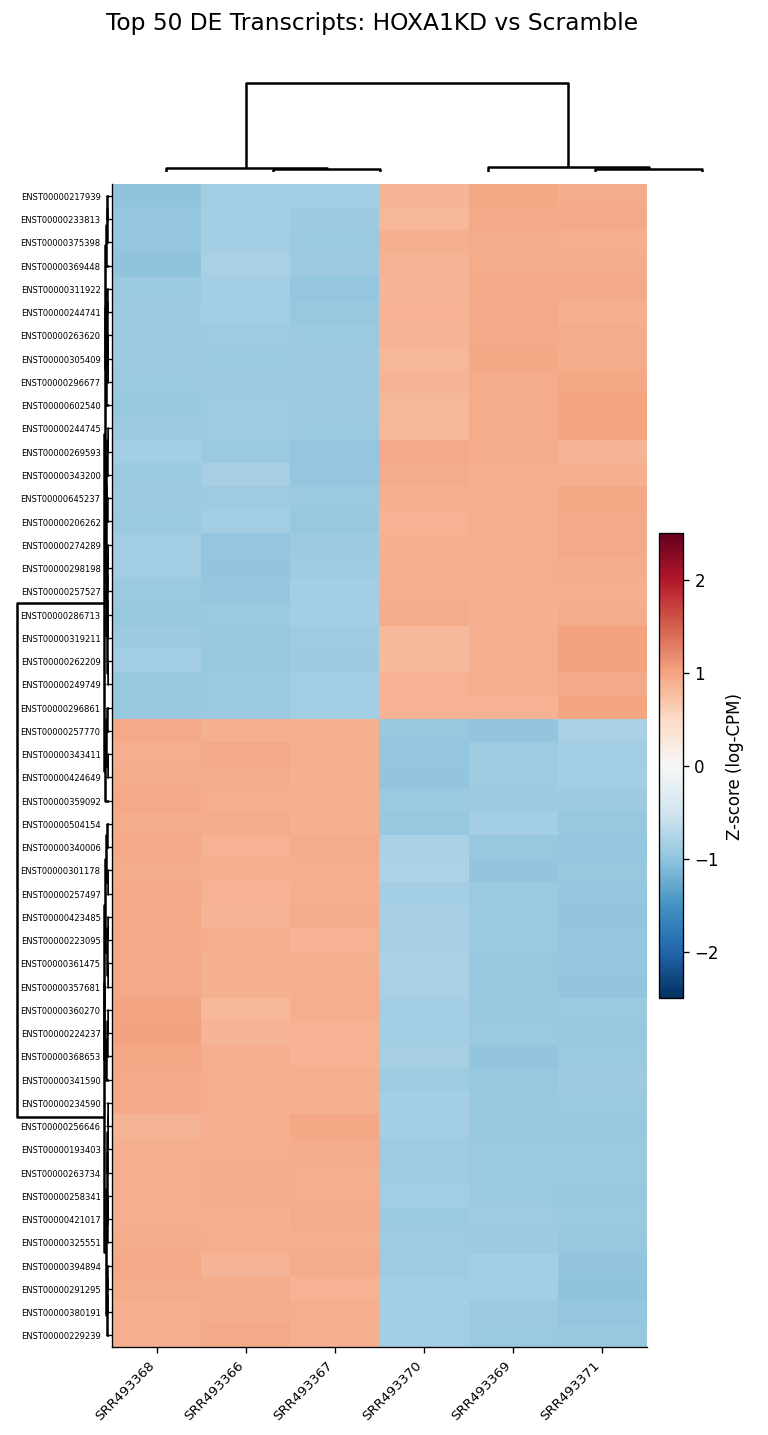

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

top50 = table.head(50)
logcpm_all = ep.cpm(d_filt, log=True)
tid_filt = d_filt['genes']['TranscriptID'].values
tid_to_idx = {tid: i for i, tid in enumerate(tid_filt)}
top50_idx = [tid_to_idx[tid] for tid in top50['TranscriptID'].values]

hm = pd.DataFrame(logcpm_all[top50_idx, :],
                   index=top50['TranscriptID'].values, columns=sample_names)
hm_z = hm.subtract(hm.mean(axis=1), axis=0).divide(hm.std(axis=1), axis=0)

row_link = linkage(pdist(hm_z.values), method='complete')
col_link = linkage(pdist(hm_z.values.T), method='complete')
row_order = dendrogram(row_link, no_plot=True)['leaves']
col_order = dendrogram(col_link, no_plot=True)['leaves']

fig = plt.figure(figsize=(8, 14))
gs = fig.add_gridspec(2, 2, width_ratios=[0.15, 1], height_ratios=[0.08, 1],
                       wspace=0.01, hspace=0.02)

# Column dendrogram
ax_cd = fig.add_subplot(gs[0, 1])
dendrogram(col_link, ax=ax_cd, color_threshold=0, above_threshold_color='black')
ax_cd.set_axis_off()

# Row dendrogram
ax_rd = fig.add_subplot(gs[1, 0])
dendrogram(row_link, ax=ax_rd, orientation='left', color_threshold=0,
           above_threshold_color='black')
ax_rd.set_axis_off()

# Heatmap
ax_heat = fig.add_subplot(gs[1, 1])
reordered = hm_z.iloc[row_order, col_order]
im = ax_heat.imshow(reordered.values, aspect='auto', cmap='RdBu_r',
                     vmin=-2.5, vmax=2.5, interpolation='none')
ax_heat.set_xticks(range(len(reordered.columns)))
ax_heat.set_xticklabels(reordered.columns, rotation=45, ha='right', fontsize=8)
ax_heat.set_yticks(range(len(reordered.index)))
# Shorten transcript IDs for display
short_ids = [tid.split('.')[0] if '.' in str(tid) else str(tid)[:15]
             for tid in reordered.index]
ax_heat.set_yticklabels(short_ids, fontsize=5)
cbar = fig.colorbar(im, ax=ax_heat, shrink=0.4, pad=0.02)
cbar.set_label('Z-score (log-CPM)', fontsize=10)
fig.suptitle('Top 50 DE Transcripts: HOXA1KD vs Scramble', fontsize=14, y=0.92)
plt.show()

## 12. Summary

In [20]:
summary = pd.DataFrame({
    'Method': ['QL F-test (FDR < 0.05)', 'TREAT |logFC| > 0.58'],
    'Up': [n_up, n_up_treat],
    'Down': [n_down, n_down_treat],
})
summary['Total DE'] = summary['Up'] + summary['Down']
summary

,Method,Up,Down,Total DE
0,QL F-test (FDR < 0.05),4123,4511,8634
1,TREAT |logFC| > 0.58,1311,1581,2892


## 13. Scaled Analysis with Bootstrap Overdispersion

When kallisto quantifications include bootstrap samples, edgePython can estimate per-transcript overdispersion to account for quantification uncertainty. This follows the approach of [Baldoni et al. (2024)](https://doi.org/10.1093/nar/gkad1167), where overdispersion estimates scale the counts to reduce false positives from transcripts with high quantification variability.

In [21]:
# Download kallisto H5 quantifications with bootstraps from CaltechDATA
import os, tempfile, zipfile, urllib.request

QUANT_URL = 'https://data.caltech.edu/records/3scww-j5644/files/GSE37704_kallisto_quantifications.zip?download=1'
quant_dir = tempfile.mkdtemp()
zip_path = os.path.join(quant_dir, 'quant.zip')
print('Downloading kallisto quantifications (411 MB)...', flush=True)
urllib.request.urlretrieve(QUANT_URL, zip_path)
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(quant_dir)
os.remove(zip_path)
quant_dir = os.path.join(quant_dir, 'quant')
print('Download complete.')

sample_names_sc = ['SRR493366', 'SRR493367', 'SRR493368',
                   'SRR493369', 'SRR493370', 'SRR493371']
paths = [f'{quant_dir}/{s}' for s in sample_names_sc]

y_sc = ep.read_data(paths, source='kallisto', format='h5',
                    labels=sample_names_sc,
                    group=np.array([0, 0, 0, 1, 1, 1]),
                    verbose=True)

overdisp = y_sc['genes']['Overdispersion'].values
print(f'\nTranscripts: {y_sc["counts"].shape[0]:,}')
print(f'Overdispersion range: {overdisp.min():.4f} — {overdisp.max():.4f}')
print(f'Overdispersion median: {np.median(overdisp):.4f}')
print(f'Transcripts with overdispersion > 1: {np.sum(overdisp > 1):,} '
      f'({100 * np.mean(overdisp > 1):.1f}%)')

Reading SRR493366, 207175 transcripts, 100 bootstraps
Reading SRR493367, 207175 transcripts, 100 bootstraps
Reading SRR493368, 207175 transcripts, 100 bootstraps
Reading SRR493369, 207175 transcripts, 100 bootstraps
Reading SRR493370, 207175 transcripts, 100 bootstraps
Reading SRR493371, 207175 transcripts, 100 bootstraps

Transcripts: 207,175
Overdispersion range: 1.0000 — 380.7756
Overdispersion median: 2.0344
Transcripts with overdispersion > 1: 188,736 (91.1%)


In [22]:
# Run standard pipeline with bootstrap-scaled counts
group_sc = np.array([0, 0, 0, 1, 1, 1])
keep_sc = ep.filter_by_expr(y_sc, group=group_sc)
print(f'Transcripts after filtering: {np.sum(keep_sc):,}')

counts_sc = y_sc['counts'][keep_sc]
genes_sc = y_sc['genes'].iloc[keep_sc].copy().reset_index(drop=True)
tx_ids_sc = y_sc['genes'].index[keep_sc]
genes_sc.index = tx_ids_sc

y_sc_filt = ep.make_dgelist(counts_sc, group=group_sc, genes=genes_sc)
y_sc_filt['samples'].index = sample_names_sc
y_sc_filt = ep.calc_norm_factors(y_sc_filt)

design_sc = np.column_stack([np.ones(6), group_sc])
y_sc_filt = ep.estimate_disp(y_sc_filt, design_sc, robust=True)
print(f'Common dispersion: {y_sc_filt["common.dispersion"]:.6f}')

fit_sc = ep.glm_ql_fit(y_sc_filt, design_sc, robust=True)
qlf_sc = ep.glm_ql_ftest(fit_sc, coef=1)

dt_sc = ep.decide_tests(qlf_sc)
n_up_sc = int(np.sum(dt_sc > 0))
n_down_sc = int(np.sum(dt_sc < 0))
print(f'\nScaled DE summary (FDR < 0.05): Up={n_up_sc:,}, Down={n_down_sc:,}')
print(f'Standard DE summary (FDR < 0.05): Up={n_up:,}, Down={n_down:,}')

Transcripts after filtering: 44,811
Common dispersion: 0.342755

Scaled DE summary (FDR < 0.05): Up=4,428, Down=4,663
Standard DE summary (FDR < 0.05): Up=4,123, Down=4,511


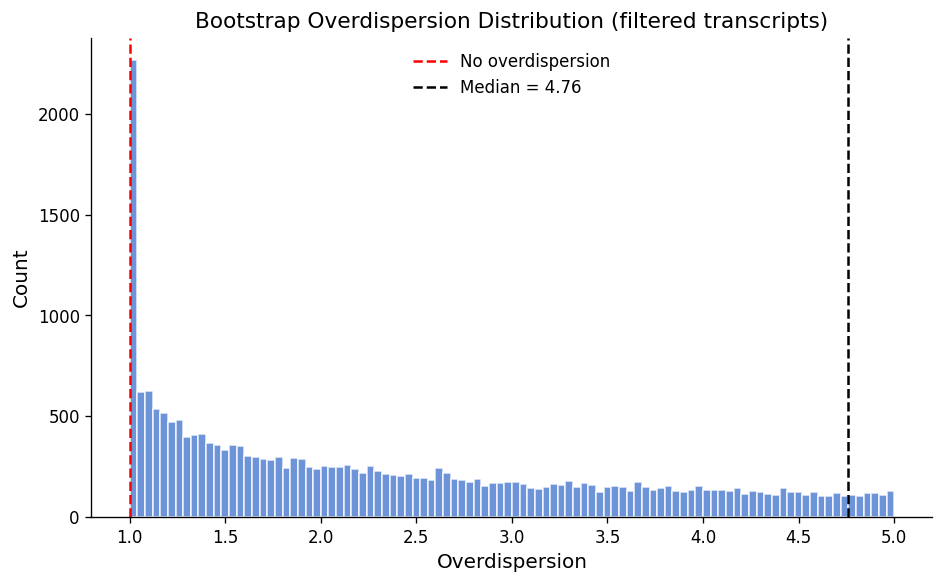

Transcripts with overdispersion > 2: 33,569 (74.9%)
Transcripts with overdispersion > 5: 21,724 (48.5%)


In [23]:
# Overdispersion distribution
fig, ax = plt.subplots(figsize=(8, 5))
od_filt = genes_sc['Overdispersion'].values
ax.hist(od_filt[od_filt <= 5], bins=100, color='#4878cf', edgecolor='white', alpha=0.8)
ax.axvline(x=1.0, color='red', linestyle='--', linewidth=1.5, label='No overdispersion')
ax.axvline(x=np.median(od_filt), color='black', linestyle='--', linewidth=1.5,
           label=f'Median = {np.median(od_filt):.2f}')
ax.set_xlabel('Overdispersion')
ax.set_ylabel('Count')
ax.set_title('Bootstrap Overdispersion Distribution (filtered transcripts)')
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

print(f'Transcripts with overdispersion > 2: {np.sum(od_filt > 2):,} '
      f'({100 * np.mean(od_filt > 2):.1f}%)')
print(f'Transcripts with overdispersion > 5: {np.sum(od_filt > 5):,} '
      f'({100 * np.mean(od_filt > 5):.1f}%)')